In [3]:
import os
import uuid
import time
import cv2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import json

In [85]:
image_dir = os.path.join(r'FaceDetection/data',)
number_of_images = 30

In [86]:
# cap = cv2.VideoCapture(0)
# for i in range(number_of_images):
#     ret,frame = cap.read()
#     imgname = os.path.join(image_dir, f"{str(uuid.uuid1())}.jpg")
#     cv2.imwrite(imgname,frame)
#     cv2.imshow('image',frame)
#     time.sleep(1)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cap' is not defined

In [87]:
# load images

images = tf.data.Dataset.list_files(os.path.join(image_dir,"train", '*.jpg'))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: FaceDetection/data\\train\\*.jpg'

In [2]:
def load_image(img):
    """
    Load image from file path
    and decode it in to tensor
    """
    byte_img = tf.io.read_file(img)
    print(byte_img)
    img = tf.image.decode_jpeg(byte_img)
    print(img)
    return img

# images = images.map(load_image)

In [52]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

ax,fig = plt.subplots(ncols=4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(plot_images[i])
    fig[i].axis('off')
plt.show()

NameError: name 'images' is not defined

In [53]:
# move the label to respective train test and val

data_dir = './data'
folders = ['train', 'test', 'val']
existing_labels = os.path.join('data', 'label')

for folder in folders:
    foldername = os.path.join(data_dir, folder)
    label_folder = os.path.join(foldername, 'label')
    os.makedirs(label_folder, exist_ok=True)
    for files in os.listdir(foldername):
        filename = files.split('.')[0]
        print((os.path.join(foldername, "label"+f"{filename}.json")))
        if os.path.exists(os.path.join(foldername, "label,"+f"{filename}.json")):
            print("exosting")
            # move them to label folder in the same folder
            os.replace(os.path.join(foldername, "label,"+f"{filename}.json"), os.path.join(label_folder, f"{filename}.json"))
          

        #     print(os.path.join(existing_labels, f"{filename}.json"))
        #     os.replace(os.path.join(existing_labels, f"{filename}.json"), os.path.join(foldername,'label,' f"{filename}.json"))




./data\train\label113acafa-852f-11ef-af93-c8e2659e55c4.json
./data\train\label11d81a27-852f-11ef-9e6e-c8e2659e55c4.json
./data\train\label12749878-852f-11ef-a79c-c8e2659e55c4.json
./data\train\label1312228c-852f-11ef-b76e-c8e2659e55c4.json
./data\train\label13b26432-852f-11ef-94c2-c8e2659e55c4.json
./data\train\label144e10ac-852f-11ef-bf08-c8e2659e55c4.json
./data\train\label14ea0164-852f-11ef-8e1b-c8e2659e55c4.json
./data\train\label1586432a-852f-11ef-a176-c8e2659e55c4.json
./data\train\label17fb3150-852f-11ef-b5bb-c8e2659e55c4.json
./data\train\label1899b921-852f-11ef-86fe-c8e2659e55c4.json
./data\train\label19d4b2fa-852f-11ef-b42f-c8e2659e55c4.json
./data\train\label1a756f89-852f-11ef-8d08-c8e2659e55c4.json
./data\train\label1b138b37-852f-11ef-8357-c8e2659e55c4.json
./data\train\label1bb16866-852f-11ef-ac40-c8e2659e55c4.json
./data\train\label1c4ed1b2-852f-11ef-b776-c8e2659e55c4.json
./data\train\label1ceac606-852f-11ef-a872-c8e2659e55c4.json
./data\train\label1d881b2b-852f-11ef-924

In [54]:
## Load image from aug_data To tf Dataset
def include_data_to_tf_dataset(data_dir):
    images = tf.data.Dataset.list_files(os.path.join(data_dir, 'images', '*.jpg'), shuffle=False)
    # make the image into an array
    images = images.map(load_image)
    images = images.map(lambda x: tf.image.resize(x, (120,120)))
    images = images.map(lambda x: x/255.0)

    return images
train_images = include_data_to_tf_dataset(os.path.join('aug_data', 'train'))
test_images = include_data_to_tf_dataset(os.path.join('aug_data', 'test'))
val_images = include_data_to_tf_dataset(os.path.join('aug_data', 'val'))




Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, None), dtype=uint8)
Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, None), dtype=uint8)
Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, None), dtype=uint8)


In [58]:
# albumentations
import albumentations as alb
augmentor = alb.Compose([
    alb.RandomCrop(width=256, height=256),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
],
bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


In [59]:
# Augumentation pipeline
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join(data_dir, partition)):
        img = cv2.imread(os.path.join(data_dir, partition, image))

        coords = [0,0,0.0001,0.0001]
        label_path = os.path.join(data_dir, partition, 'label', f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path) as f:
                label = json.load(f)
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords,[640,480,640,480]))
                print(coords)


                try:
                    for x in range(60):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                        cv2.imwrite(os.path.join('aug_data', partition, 'images',f"{image.split('.')[0]}_{str(x)}.jpg"), augmented['image'])
                        
                        annotaions = {}
                        annotaions['image'] = image
                        # print(augmented)
                        # print(augmented['bboxes'])
                        # print(label_path)
                        # break
 
                        if os.path.exists(label_path):
                            # print(label_path)
                            if len(augmented['bboxes'])==0:
                                print("No bboxes")
                                annotaions['bbox'] = [0,0,0,0]
                                annotaions['class'] = 0
                            else:
                                print(augmented['bboxes'])
                                annotaions['bbox'] = augmented['bboxes'][0]
                                annotaions['class'] = 1
                        else:
                            annotaions['bbox'] = [0,0,0,0]
                            annotaions['class'] = 0


                        with open(os.path.join('aug_data', partition, 'labels', f"{image.split('.')[0]}_{str(x)}.json"), 'w') as f:
                            json.dump(annotaions, f)
                except Exception as e:
                    print()
                    print(f"Error in {image} {e}")

[0.40942651098901095, 0.5915750915750915, 0.6815762362637363, 0.9899267399267399]
[[0.37027812004089355, 0.4763907864689827, 1.0, 1.0]]
No bboxes
[[0.17105937004089355, 0.0, 0.8514337241649628, 0.4845467135310173]]
[[0.5391912758350372, 0.0, 1.0, 0.0861092135310173]]
No bboxes
No bboxes
[[0.45230937004089355, 0.5662345364689827, 1.0, 1.0]]
[[0.39371562004089355, 0.3787345364689827, 1.0, 1.0]]
[[0.0, 0.5545157864689827, 0.29674622416496277, 1.0]]
[[0.09684062004089355, 0.0, 0.7772149741649628, 0.3087654635310173]]
[[0.18762877583503723, 0.7185782864689827, 0.8680031299591064, 1.0]]
No bboxes
[[0.33997252583503723, 0.9177970364689827, 1.0, 1.0]]
[[0.34387877583503723, 0.0, 1.0, 0.4689217135310173]]


c:\All\Programming\DataScience\Vision\FaceDetection\face_detect\lib\site-packages\albumentations\core\bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


[[0.0, 0.0, 0.35533997416496277, 0.7111092135310173]]
[[0.03919127583503723, 0.6131095364689827, 0.7195656299591064, 1.0]]
[[0.29700377583503723, 0.5545157864689827, 0.9773781299591064, 1.0]]
[[0.23841002583503723, 0.8240470364689827, 0.9187843799591064, 1.0]]
[[0.5577781200408936, 0.7263907864689827, 1.0, 1.0]]
[[0.7149725258350372, 0.0, 1.0, 0.6759529635310173]]
[[0.0, 0.9021720364689827, 0.5154962241649628, 1.0]]
[[0.0, 0.3982657864689827, 0.34752747416496277, 1.0]]
[[0.43372252583503723, 0.0, 1.0, 0.7306404635310173]]
[[0.0, 0.0, 0.6131524741649628, 0.2072029635310173]]
[[0.0, 0.011074833571910858, 0.29674622416496277, 0.7579842135310173]]
[[0.0, 0.0, 0.6561212241649628, 0.0861092135310173]]
[[0.5538718700408936, 0.0, 1.0, 0.7189217135310173]]
No bboxes
No bboxes
[[0.6398093700408936, 0.0, 1.0, 0.1876717135310173]]
No bboxes
No bboxes
No bboxes
[[0.0, 0.0, 0.42174622416496277, 0.0587654635310173]]
[[0.6241843700408936, 0.8670157864689827, 1.0, 1.0]]
[[0.038246870040893555, 0.249828

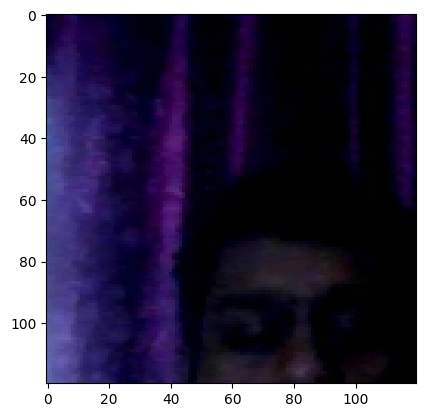

In [60]:
plt.imshow(train_images.as_numpy_iterator().next())

In [61]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']


In [62]:
train_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'train', 'labels', '*.json'),shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'test', 'labels', '*.json'),shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files(os.path.join('aug_data', 'val', 'labels', '*.json'),shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))




In [63]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3704, 0.4763, 1.    , 1.    ], dtype=float16))

# Merge The image and label

In [64]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2700, 2700, 240, 240, 420, 420)

In [65]:
def merge_images_labels(images, labels):
    dataset = tf.data.Dataset.zip(((images), labels))
    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(4)
    return dataset

In [66]:
train = merge_images_labels(train_images, train_labels)
test = merge_images_labels(test_images, test_labels)
val = merge_images_labels(val_images, val_labels)

In [67]:
test.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

## 8 images 120x120 3->rgb

In [68]:
res = test.as_numpy_iterator().next()

In [69]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
# train = np.array(train)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
# test = test.prefetch(4)
# test = np.array(test)


Image shape: (120, 120, 3)
(93, 0)
(120, 31)
Image shape: (120, 120, 3)
(0, 42)
(120, 109)
Image shape: (120, 120, 3)
(84, 51)
(120, 120)
Image shape: (120, 120, 3)
(0, 28)
(120, 96)


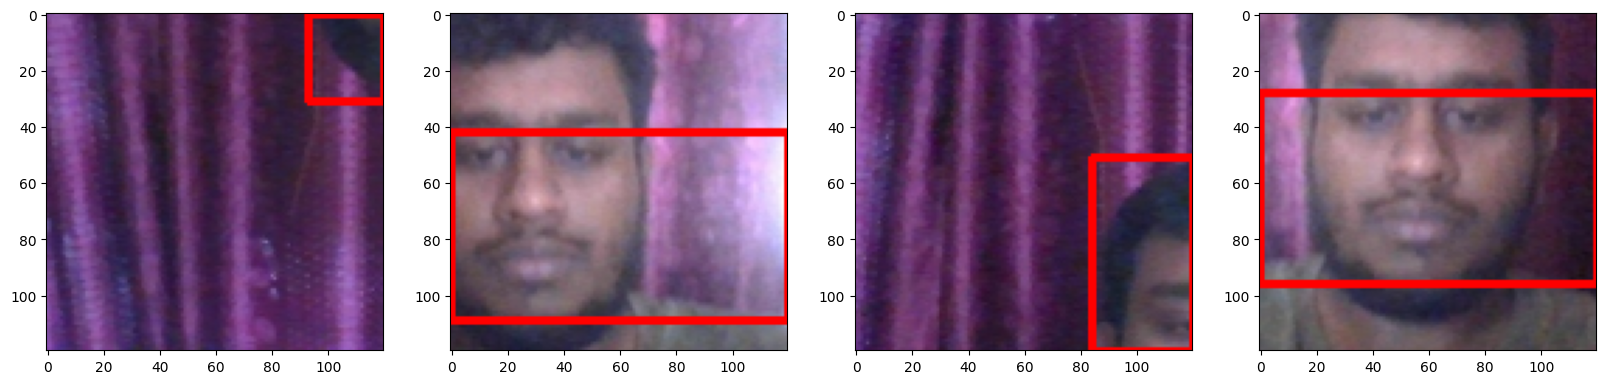

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_image = np.array(sample_image)
    sample_coords = res[1][1][idx]
    
    # Print values for debugging
    print("Image shape:", sample_image.shape)
    print(tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)))
    print(tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)))
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [71]:
# vizualize the data
data_sample = train.as_numpy_iterator()
res = data_sample.next()

# Creating the neural network

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16



In [73]:
def build_model():
    input_layer = Input(shape=(120,120,3)) 

    vgg = VGG16(include_top=False)(input_layer)

    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker



In [74]:
facetracker = build_model()

In [75]:
facetracker.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      2,049 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4)         │      8,196 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
X,y = train.as_numpy_iterator().next()

In [77]:
batch_per_epoch = 465
lr_decay = (1/0.75-1)/batch_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001,decay = lr_decay)

c:\All\Programming\DataScience\Vision\FaceDetection\face_detect\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [78]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:2]-yhat[:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(h_true-h_pred) + tf.square(w_true-w_pred))

    return delta_coord + delta_size

In [79]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [80]:
localization_loss(y[1], facetracker(X)[1])

<tf.Tensor: shape=(), dtype=float32, numpy=4.3846264>

# Create a custom model

In [81]:
class FaceTracker(tf.keras.Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.closs = classloss
        self.lloss = localization_loss

    def train_step(self, batch, **kwargs):
        X, y = batch
        # Ensure y[0] shape matches classes
        with tf.GradientTape() as tape:
            # Forward pass
            classes, coords = self.model(X, training=True)
            print(classes)
            # Calculate losses
            # Calculate class loss
            y_class = tf.reshape(y[0], shape=tf.shape(classes))
            batch_classloss = self.closs(y_class, classes)
            batch_localization = self.lloss(tf.cast(y[1], tf.float32), coords)

            # Total loss
            total_loss = 0.5 * batch_classloss + batch_localization

        # Compute gradients
        grads = tape.gradient(total_loss, self.model.trainable_variables)

        # Apply gradients
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        # Return loss values for tracking
        return {"Total loss": total_loss, "Class loss": batch_classloss, "Localization loss": batch_localization}

    def test_step(self, batch, **kwargs):
        X, y = batch
        # Forward pass
        classes, coords = self.model(X, training=False)

        # Calculate losses
        print(classes)
        # y[0] = tf.cast(y[0], tf.float32)
        # Ensure y[0] shape matches classes
        y_class = tf.reshape(y[0], shape=tf.shape(classes))

        # Calculate class loss
        batch_classloss = self.closs(y_class, classes)
        batch_localization = self.lloss(tf.cast(y[1], tf.float32), coords)

        # Total loss
        total_loss = 0.5 * batch_classloss + batch_localization

        return {"Total loss": total_loss, "Class loss": batch_classloss, "Localization loss": batch_localization}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [82]:
model = FaceTracker(facetracker)
model.compile(opt, classloss,regressloss)

In [ ]:
logdir = 'logs'
tensorboard = tf.keras.callbacks.TensorBoard(logdir)

hist = model.fit(train.take(10), validation_data=val, epochs=40, callbacks=[tensorboard])

Epoch 1/40


In [1]:
hist.history

NameError: name 'hist' is not defined

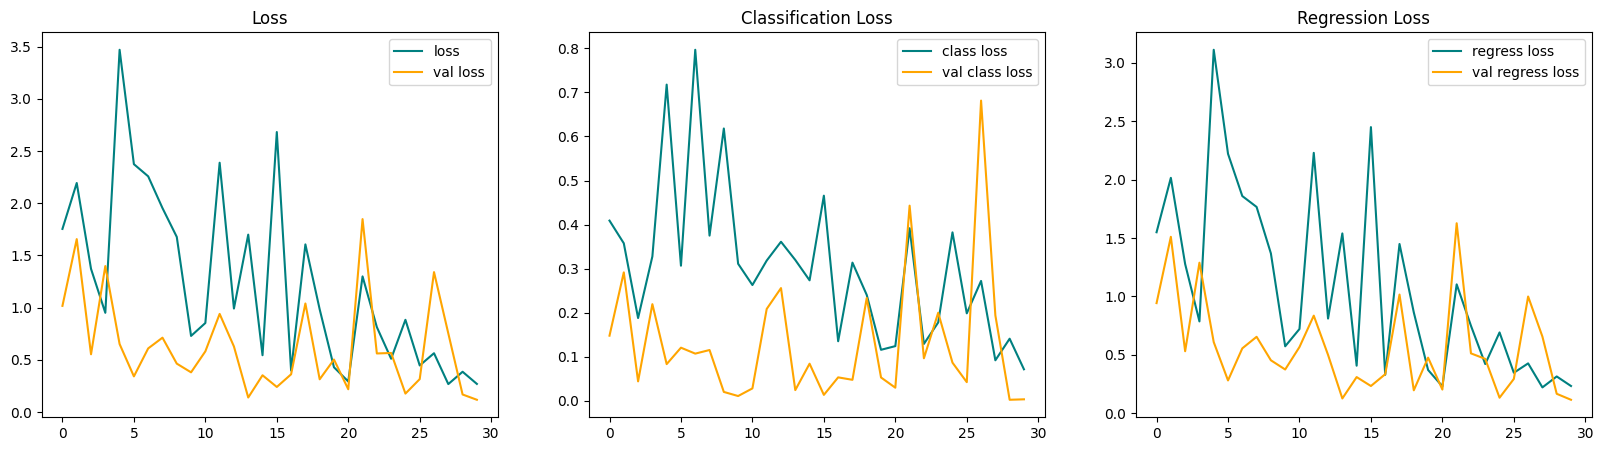

In [165]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['Total loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_Total loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['Class loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_Class loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['Localization loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_Localization loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [167]:
test_data = test.as_numpy_iterator().next()



ythat = facetracker.predict(test_data[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Image shape: (120, 120, 3)
(43, 4)
(105, 106)
Image shape: (120, 120, 3)
(2, 3)
(15, 100)
Image shape: (120, 120, 3)
(6, 2)
(86, 77)
Image shape: (120, 120, 3)
(37, 2)
(108, 113)


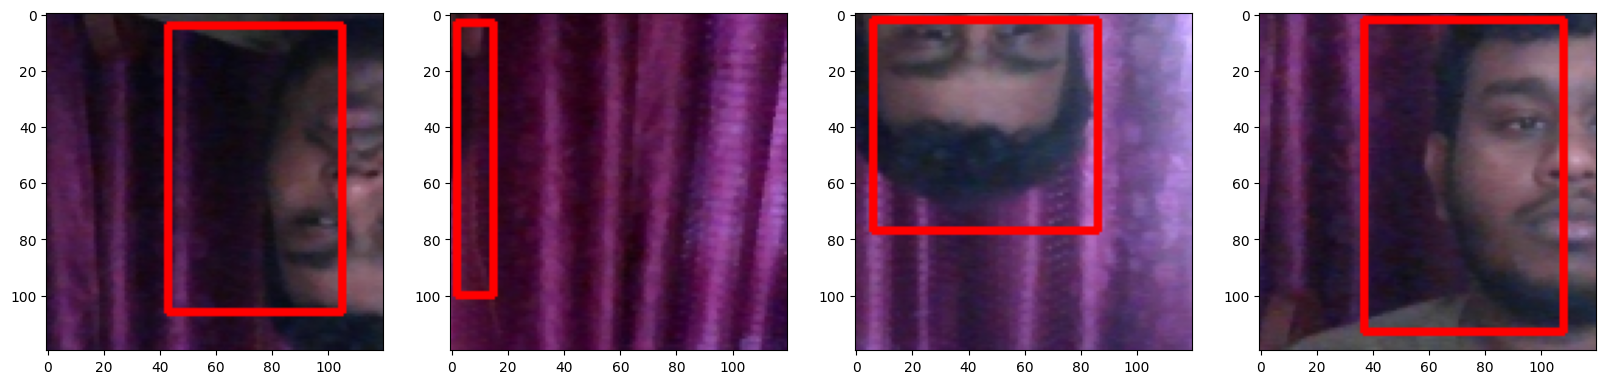

In [169]:
fig , ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_data[0][idx]
    sample_image = np.array(sample_image)
    sample_coords = ythat[1][idx]

    print("Image shape:", sample_image.shape)
    print(tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)))
    print(tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)))
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Save the model and predict unknown


In [4]:
from tensorflow.keras.models import load_model
import cv2
import tensorflow as tf

facetracker.save('facetracker.h5')


NameError: name 'facetracker' is not defined

In [8]:
facetracker = load_model('facetracker.h5')


In [9]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()